In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate

import os
import psycopg2

from dotenv import load_dotenv
import logging
from tqdm import tqdm
import multiprocessing
import time

import sys
sys.path.append("/home/mylab-pharma/Code/tuele/XO/src/common")
from pharmacy_common import PharmacyCommon
#Rdkit ultis
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import MACCSkeys

#class to encode smiles
common = PharmacyCommon()

In [2]:
def cal_tc(array1, array2):
    if len(array1) != len(array2):
        raise ValueError("The arrays must have the same length.")
    
    # Calculate the Tanimoto coefficient
    intersection = sum(a and b for a, b in zip(array1, array2))
    union = sum(a or b for a, b in zip(array1, array2))
    
    if union == 0:  # Handle the case when both arrays are all zeros
        return 0.0
    else:
        tanimoto_coefficient = intersection / union
        return tanimoto_coefficient


In [3]:
def calculate_distances(identifier, screening_vectors, X_Train):
    distances = []
    for screening_vector in screening_vectors:
        tc_dist = np.sum(screening_vector & X_Train, axis=1) / np.sum(screening_vector | X_Train, axis=1)
        distances.append(tc_dist)
    return identifier, distances

def find_nearest_neighbors_distance(X_Screening, X_Train, n_neighbors):
    nearest_neighbors_distances = []
    nearest_neighbors_indices = []
    X_Screening = np.array(X_Screening)
    X_Train = np.array(X_Train)
    if(np.size(X_Screening) == 0):
        return nearest_neighbors_distances, nearest_neighbors_indices
     
    if X_Screening.shape[1] != X_Train.shape[1]:
        raise ValueError("X_Screening bit vectors must have the same size as X_Train bit vectors: " + str(X_Train.shape[1]))

    num_processes = 6
    
    if len(X_Screening) <= num_processes:
        screening_chunks = [(i, X_Screening[i:i + 1]) for i in range(len(X_Screening))]
    else:
        chunk_size = len(X_Screening) // num_processes
        screening_chunks = [(i, X_Screening[i:i + chunk_size]) for i in range(0, len(X_Screening), chunk_size)]

    pool = multiprocessing.Pool(processes=num_processes)
    results = pool.starmap(calculate_distances, [(i, chunk, X_Train) for i, chunk in screening_chunks])
    pool.close()
    pool.join()

    # Sort the results by identifier to ensure the correct order
    results.sort(key=lambda x: x[0])

    # Extract the distances and indices
    for _, distances in results:
        for distance in distances:
            # Get the indices of the first n_neighbors elements with the largest Tanimoto coefficients
            nearest_neighbor_indices = np.argsort(distance)[::-1][:n_neighbors]

            # Extract the distances to the nearest neighbors
            nearest_neighbors_distances.append([distance[i] for i in nearest_neighbor_indices])
            nearest_neighbors_indices.append(nearest_neighbor_indices)

    return nearest_neighbors_distances, nearest_neighbors_indices

In [60]:
def update_average_distance(screening_data, n_neighbors, X_train, bits):
    logging.info(f"[+] Update average distance for screening dataset")
    working_dataset = screening_data
    if(len(working_dataset)>0):
        X_Screening = common.gen_ecfp4_fpts(working_dataset["SMILES"], bits)
        # X_Screening = common.gen_maccs_fpts(working_dataset["SMILES"])
        logging.info(f"[-] Start finding nearest neighbor for: {len(X_Screening)}")
        #Find nearest neighbor
        dist_array, nn_idx = find_nearest_neighbors_distance(X_Screening=X_Screening, n_neighbors=n_neighbors, X_Train=X_train)
        result_df = pd.DataFrame({'SMILES': working_dataset['SMILES'], 
                                 'AVG_DISTANCE': np.average(dist_array, axis=1)})
    else:
        logging.info("[-] Empty data, skip this batch!")
        print("[-] Empty data, skip this batch!")    
    return result_df

Split all screen_data with 25000 smiles

In [54]:
screening_data_path = "../../data/screening_dataset/preprocessed_screening_dataset.xlsx"
screening_data = pd.read_excel(screening_data_path, sheet_name='final_screening_data')
print(len(screening_data))
screening_data.head(10)

406925


,SMILES
0,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...
1,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...
2,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...
3,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...
4,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...
5,O=C1OC(C)C(O)C12C(O)C(O)CCC2C
6,O=C1OC2C(OC(=O)C)C=CC3C4=C5C(=O)C=6C(OC(=O)C)=...
7,O=C(OCCC1(C)CC(OC(=O)C)C(OC(=O)C)C2CC(C)(C)CC21)C
8,O=CCC1(C)CC(=O)C(O)C2CC(C)(C)CC21
9,O=C1C=2C=CC=C(OC)C2C(=O)C3=C(OC)C=C4C(=C13)C5C...


Splitting the all_screening_dataset into 10 subsets

In [55]:

total_rows = len(screening_data)
len_each_subset = 41000
num_splits = (total_rows // len_each_subset) + (1 if total_rows % len_each_subset != 0 else 0)

data_splits = []
for i in range(num_splits):
    start = i * len_each_subset
    end = min((i + 1) * len_each_subset, total_rows)
    data_splits.append(screening_data.iloc[start:end])
for i, split in enumerate(data_splits):
    print(f"Subset {i} has {len(split)} rows")

Subset 0 has 41000 rows
Subset 1 has 41000 rows
Subset 2 has 41000 rows
Subset 3 has 41000 rows
Subset 4 has 41000 rows
Subset 5 has 41000 rows
Subset 6 has 41000 rows
Subset 7 has 41000 rows
Subset 8 has 41000 rows
Subset 9 has 37925 rows


In [56]:
train_test_path = "../../data/train_test_data/XO_train_test_data.xlsx"
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
#Fingerprint ECFP4, MACCS
print(len(train_dataset))
train_dataset.head(10)

337


,CID,SMILES,IC50(nM),Type,substructure
0,145967694,CC1=CC2=C(C=C1)N=C(O2)/C(=N/O)/CC3=CC=CC=C3,17500.0,active,7
1,76329670,CC1(C=CC2=CC(=C(C=C2O1)O)C(=O)/C=C/C3=CC(=C(C=...,1800.0,inactive,16
2,5320686,C1=CC(=CC=C1/C=C/C(=O)OC[C@@H]2[C@H]([C@@H]([C...,100000.0,active,6
3,155903284,C1=CC(=CC=C1C2=NC=NN2)NC(=O)C3C(NC(=O)NC3=O)O,1400.0,inactive,1
4,137648214,CCCCC1=NN2C(=N1)C3=C(NC2=O)NN=C3,529.0,inactive,9
5,156780202,C1=CC=C(C=C1)CN2C=C(C3=C2C=CC(=C3)NC(=O)C4=CC(...,820.0,inactive,3
6,135463610,CCCCSC1=NC(=C(C(=O)N1)NC=O)N,100000.0,active,3
7,156705027,C1=CC(=CC=C1COC2=C(C=C(C=C2)C3=NC=C4C(=N3)NNC4...,151.0,inactive,3
8,162680022,C1=CN=C(C=C1NC(=O)C2C(NC(=O)NC2=O)O)C(=O)NO,73800.0,active,7
9,24896701,CCC[C@H](C[C@@H]1[C@@H](C2=CC(=C(C(=C2C(=O)O1)...,612000.0,active,2


In [57]:
all_result = pd.DataFrame()

In [96]:
# subset i, i : 0 -> 9
i = 9
screen_dataset = data_splits[i] 

In [97]:
fpt_bits = 1024
X_Train = common.gen_maccs_fpts(train_dataset['SMILES'])
# X_Train = common.gen_ecfp4_fpts(train_dataset['SMILES'],bits = fpt_bits)

# nn_nums: numbers of nearest-neighbors
## AD for MACCS, ECFP4 1024bits
nn_nums = 5
result= update_average_distance(screening_data=screen_dataset, n_neighbors=nn_nums,X_train = X_Train, bits= fpt_bits)

Progress: 100%|██████████| 37925/37925 [00:48<00:00, 776.28it/s]


In [98]:
result.head(10)

,SMILES,AVG_DISTANCE
369000,O=C1C2=C(OCCCO)C(OC)=C(OCCC=3C=CC=CC3)C(=C2[OH...,0.716473
369001,O=C(O)CSCCSCC(=O)O,0.443845
369002,O=C(OC1CC(=O)CC(C2=CC(O)=C(OC=3C=CC=C(O)C3)C(O...,0.573268
369003,ClC=1C=C(Cl)C(OCCNCC(O)C)=C(Cl)C1,0.486917
369004,O=C1C2=C3C(C)(C1)C4(C)CCC5C(C(=O)CCC5(C)C4C(O)...,0.570694
369005,O=C(NC=1C=2C=CC=CC2N=C3C1CCC3)CN4CCN(C)CC4,0.611789
369006,O=C(OC1CC(=O)CC(C#CCNC2=CC(=CCN2)C3(CC4=CNC=C4...,0.560270
369007,O=C(OCC)C(NC(=O)C=1C=CC=CC1)CSC(=O)C(C)(C)CO[N...,0.416704
369008,N=C(N)C(N=NC(C(=N)N)(C)C)(C)C,0.324446
369009,S=S(C1=C(OC)C(OC)=C(C2=C1C(OC)SCC2)N(C)C)C,0.460252


In [99]:
# all_result = result
all_result = pd.concat([all_result ,result],ignore_index=True, axis =0)
print(len(all_result))
all_result.head(10)

406925


,SMILES,AVG_DISTANCE
0,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,0.575586
1,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C(OC)=CC=C(OC)C6C...,0.695284
2,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,0.695284
3,O=C(OC1CC(C)(CCOC(=O)C(C)(C)C)C2CC(C)(C)CC2C1O...,0.657312
4,O=C1OC2C(O)C=CC3C4=C5C(=O)C=6C=CC=C(O)C6C(=O)C...,0.700441
5,O=C1OC(C)C(O)C12C(O)C(O)CCC2C,0.652018
6,O=C1OC2C(OC(=O)C)C=CC3C4=C5C(=O)C=6C(OC(=O)C)=...,0.697876
7,O=C(OCCC1(C)CC(OC(=O)C)C(OC(=O)C)C2CC(C)(C)CC21)C,0.663761
8,O=CCC1(C)CC(=O)C(O)C2CC(C)(C)CC21,0.610955
9,O=C1C=2C=CC=C(OC)C2C(=O)C3=C(OC)C=C4C(=C13)C5C...,0.700109


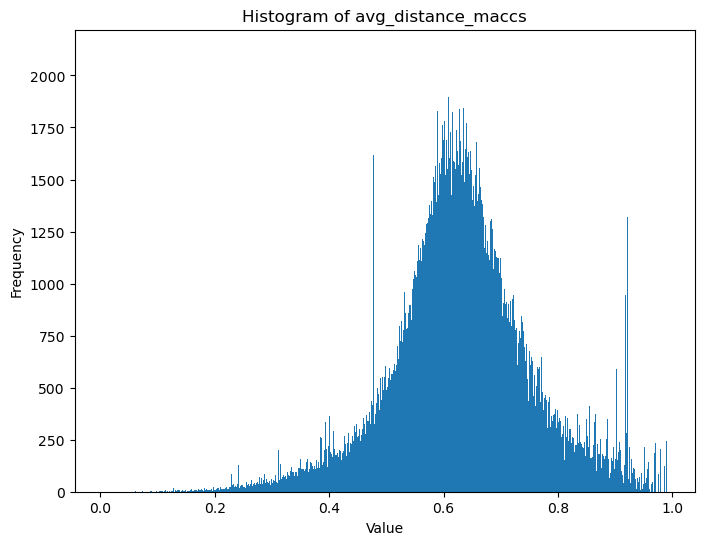

In [103]:
import matplotlib.pyplot as plt
avg_distance_maccs = all_result["AVG_DISTANCE"]
avg_distance = np.array(avg_distance_maccs)

plt.figure(figsize=(8, 6))  # Set the figure size
plt.hist(avg_distance, bins=1000)  # Create the histogram with 20 bins
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of avg_distance_maccs')

# Show the plot
plt.show()  

In [1]:
threshold = 0.8
screen_dataset_maccs= all_result[all_result["AVG_DISTANCE"]>threshold]
print(len(screen_dataset_maccs))
screen_dataset_maccs.head()

NameError: name 'all_result' is not defined

In [104]:
#write to file excel
# all_result.to_excel("/home/mylab-pharma/Code/tuele/XO/results/average_distance/avg_distance_MACCS.xlsx", index=False)
all_result.to_excel("/home/mylab-pharma/Code/tuele/XO/results/average_distance/avg_distance_ECFP4.xlsx", index=False)